In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from feast import FeatureStore

In [2]:
df0 = pd.read_csv('Paste path from CSV folder for taxi_zone_lookup.csv')
df0.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [3]:
# import the google creds 
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'Enter path of GCPKey'

<>:3: DeprecationWarning: invalid escape sequence '\O'


In [ ]:
from feast import FeatureStore
from google.cloud import bigquery

# 1. Set up Feast and BQ clients
fs = FeatureStore(repo_path="Paste path of the feature repo created...")
bq = bigquery.Client()

entity_keys = bq.query("""
    SELECT trip_id, pickup_ts
    FROM `opportune-baton-464110-c1.VLBA.Taxi_data_features_split`
    WHERE split = 'dev'
""").to_dataframe()

# Fetch historical features for those entities
feature_refs = [
    "taxi_features:pickup_bin",
    "taxi_features:dropoff_bin",
    "taxi_features:trip_time_s",
    "taxi_features:passenger_count",
    "taxi_features:trip_distance",
    "taxi_features:RatecodeID",
    "taxi_features:PULocationID",
    "taxi_features:DOLocationID",
    "taxi_features:total_surcharges",
    "taxi_features:airport_fee",
    "taxi_features:total_amount"
]

df_all = fs.get_historical_features(
    entity_keys,
    feature_refs
).to_df()

# 4. Print the result
print(df_all.head())

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17051639 entries, 0 to 17051638
Data columns (total 13 columns):
 #   Column            Dtype              
---  ------            -----              
 0   trip_id           object             
 1   pickup_ts         datetime64[us, UTC]
 2   pickup_bin        int64              
 3   dropoff_bin       int64              
 4   trip_time_s       int64              
 5   passenger_count   float64            
 6   trip_distance     float64            
 7   RatecodeID        float64            
 8   PULocationID      int64              
 9   DOLocationID      int64              
 10  total_surcharges  float64            
 11  airport_fee       float64            
 12  total_amount      float64            
dtypes: datetime64[us, UTC](1), float64(6), int64(5), object(1)
memory usage: 1.7+ GB


In [5]:
df_full = df_all[["pickup_bin", "dropoff_bin", "trip_time_s", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "total_surcharges", "airport_fee", "total_amount"]]
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17051639 entries, 0 to 17051638
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pickup_bin        int64  
 1   dropoff_bin       int64  
 2   trip_time_s       int64  
 3   passenger_count   float64
 4   trip_distance     float64
 5   RatecodeID        float64
 6   PULocationID      int64  
 7   DOLocationID      int64  
 8   total_surcharges  float64
 9   airport_fee       float64
 10  total_amount      float64
dtypes: float64(6), int64(5)
memory usage: 1.4 GB


In [7]:
df_full.head(10)

,pickup_bin,dropoff_bin,trip_time_s,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_surcharges,airport_fee,total_amount
0,1,1,382,1.0,1.30,1.0,162,50,7.5,0.0,16.30
1,1,1,629,1.0,2.97,1.0,141,224,5.0,0.0,23.04
2,1,1,902,1.0,4.02,1.0,186,75,5.0,0.0,29.76
3,1,1,161,1.0,0.88,1.0,141,141,5.0,0.0,11.50
4,1,1,1128,2.0,3.51,1.0,249,229,5.0,0.0,26.30
5,1,1,426,1.0,1.42,1.0,186,50,5.0,0.0,17.16
6,1,1,668,2.0,2.51,1.0,249,233,5.0,0.0,22.20
7,1,1,610,1.0,2.50,1.0,142,236,7.5,0.0,20.50
8,1,1,675,1.0,2.93,1.0,148,87,5.0,0.0,21.60
9,1,1,182,2.0,0.86,1.0,230,142,5.0,0.0,10.80


In [8]:
df_full.isna().sum()

pickup_bin          0
dropoff_bin         0
trip_time_s         0
passenger_count     0
trip_distance       0
RatecodeID          0
PULocationID        0
DOLocationID        0
total_surcharges    0
airport_fee         0
total_amount        0
dtype: int64

###Exploratory Data Analysis

Steps:
1. Merge - Airport Fee columns
2. Covert attributes 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' to bins and trip_time
3. Encode attribute store_and_fwd_flag
4. Null value treatment: replace with mean
5. Outlier treatment - pending (should be based on full data)

In [9]:
df_full.describe()

,pickup_bin,dropoff_bin,trip_time_s,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,total_surcharges,airport_fee,total_amount
count,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07,1.705164e+07
mean,4.199564e+00,4.208134e+00,8.903532e+02,1.381999e+00,3.097999e+00,1.480698e+00,1.663201e+02,1.648350e+02,5.893617e+00,1.088645e-01,2.658552e+01
std,1.427553e+00,1.447354e+00,6.229153e+02,8.788938e-01,3.665884e+00,6.601132e+00,6.402395e+01,6.932925e+01,2.821299e+00,3.941777e-01,1.811268e+01
min,1.000000e+00,1.000000e+00,4.100000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.500000e+00
25%,3.000000e+00,3.000000e+00,4.480000e+02,1.000000e+00,1.080000e+00,1.000000e+00,1.320000e+02,1.140000e+02,4.000000e+00,0.000000e+00,1.575000e+01
50%,4.000000e+00,4.000000e+00,7.230000e+02,1.000000e+00,1.780000e+00,1.000000e+00,1.620000e+02,1.620000e+02,5.000000e+00,0.000000e+00,2.052000e+01
75%,5.000000e+00,5.000000e+00,1.147000e+03,1.000000e+00,3.210000e+00,1.000000e+00,2.340000e+02,2.340000e+02,6.500000e+00,0.000000e+00,2.900000e+01
max,6.000000e+00,6.000000e+00,3.219000e+03,6.000000e+00,1.833000e+01,9.900000e+01,2.650000e+02,2.650000e+02,8.750000e+01,1.750000e+00,9.666000e+01


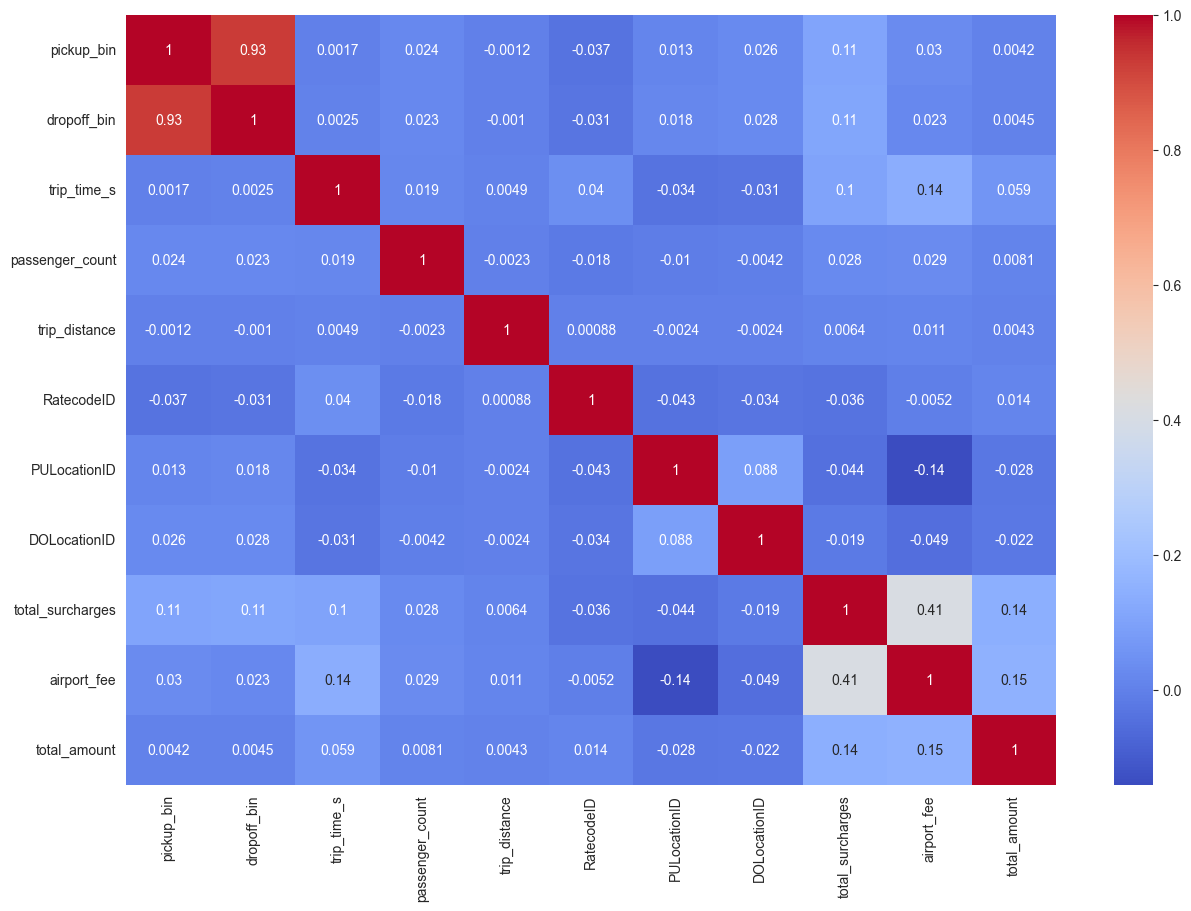

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_full.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.show()

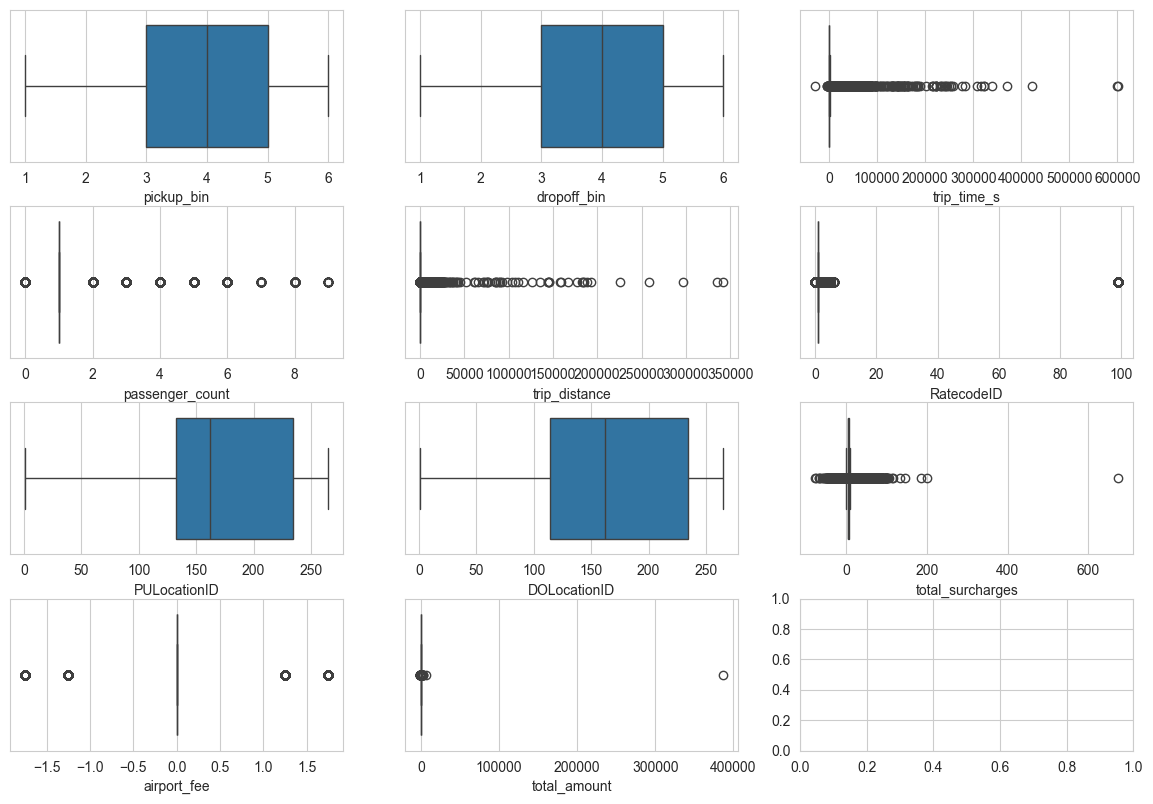

In [14]:
df_num = df_full.select_dtypes(np.number)
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (12,8))
plt.tight_layout()
for var, subplot in zip(df_num.columns, ax.flatten()):
    sns.boxplot(x = df_full[var], ax = subplot)
plt.show()

In [6]:
# List of 4 attributes to check for outliers
selected_attributes = ['trip_time_s', 'trip_distance', 'RatecodeID', 'total_surcharges', 'total_amount']  # replace with your actual column names

# Calculate Q1 and Q3 for the selected attributes
Q1 = df_full[selected_attributes].quantile(0.25)
Q3 = df_full[selected_attributes].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Identify rows that are NOT outliers on any of the selected attributes
non_outlier_mask = ~((df_full[selected_attributes] < (Q1 - 10 * IQR)) |
                     (df_full[selected_attributes] > (Q3 + 10 * IQR))).any(axis=1)

# Apply the mask to the full DataFrame
df_full_treated = df_full[non_outlier_mask]

# Check the new shape
df_full_treated.shape

(16483145, 11)

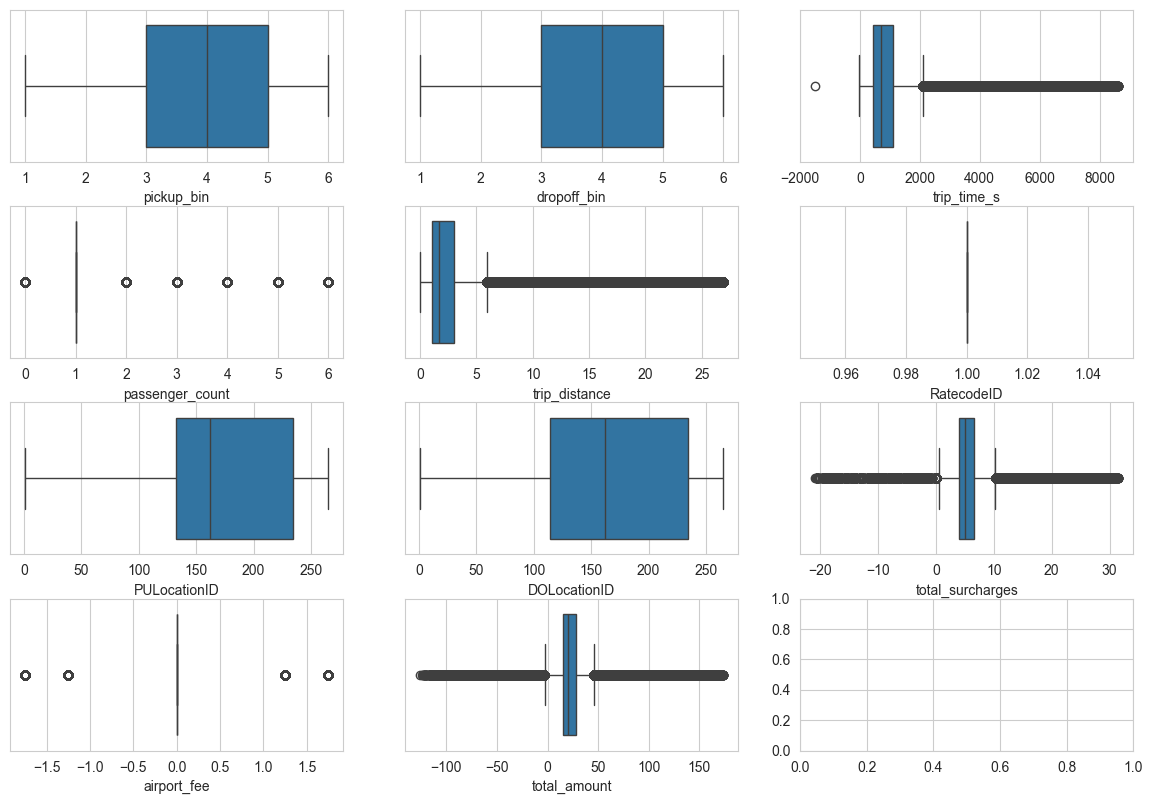

In [54]:
df_num = df_full_treated.select_dtypes(np.number)
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (12,8))
plt.tight_layout()
for var, subplot in zip(df_num.columns, ax.flatten()):
    sns.boxplot(x = df_full_treated[var], ax = subplot)
plt.show()

In [7]:
df_full = df_full_treated

Regression:

1. Dattime columns - pending
2. Scaling - pending
3. Train - Test split
4. Regression
5. Evaluation Metrics
6. Hyperparameter tuning - pending
7. Evaluation - pending

In [8]:
from sklearn.model_selection import train_test_split

X = df_full.drop(['total_amount'], axis = 1)
y = df_full['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size = 0.3)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(11538201, 4944944, 11538201, 4944944)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11538201 entries, 14258424 to 8612088
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pickup_bin        int64  
 1   dropoff_bin       int64  
 2   trip_time_s       int64  
 3   passenger_count   float64
 4   trip_distance     float64
 5   RatecodeID        float64
 6   PULocationID      int64  
 7   DOLocationID      int64  
 8   total_surcharges  float64
 9   airport_fee       float64
dtypes: float64(5), int64(5)
memory usage: 968.3 MB


In [11]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models.signature import infer_signature
from mlflow.sklearn import log_model

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

# Infer signature and prepare input example
input_example = pd.DataFrame(X_train[:5], columns=X_train.columns)
signature = infer_signature(X_train, y_hat_train)

In [14]:
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

experiment_name = "Linear Regression"
if not client.get_experiment_by_name(experiment_name):
    client.create_experiment(experiment_name)


In [15]:
# Start an MLflow run

with mlflow.start_run():
    print("Artifact URI:", mlflow.get_artifact_uri())

    # Log the model
    mlflow.sklearn.log_model(sk_model=lr, artifact_path="linear_model", input_example=input_example, signature=signature,registered_model_name="MyLinearModelProd")

    # Log metrics
    mlflow.log_metric("train_r2", r2_score(y_train, y_hat_train))
    mlflow.log_metric("train_rmse", np.sqrt(mean_squared_error(y_train, y_hat_train)))
    mlflow.log_metric("train_mae", mean_absolute_error(y_train, y_hat_train))

    # Test metrics
    mlflow.log_metric("test_r2", r2_score(y_test, y_hat_test))
    mlflow.log_metric("test_rmse", np.sqrt(mean_squared_error(y_test, y_hat_test)))
    mlflow.log_metric("test_mae", mean_absolute_error(y_test, y_hat_test))

    # log parameters
    mlflow.log_param("fit_intercept", lr.get_params()["fit_intercept"])

2025/07/02 14:18:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Artifact URI: /mlflow/artifacts/0/9be7871c44cf40a3ad5133b28d2f1921/artifacts


c:\Users\Jayant Pardhe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Successfully registered model 'MyLinearModelProd'.
2025/07/02 14:19:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MyLinearModelProd, version 1
Created version '1' of model 'MyLinearModelProd'.


🏃 View run receptive-skunk-193 at: http://localhost:5000/#/experiments/0/runs/9be7871c44cf40a3ad5133b28d2f1921
🧪 View experiment at: http://localhost:5000/#/experiments/0
